# Experimenting with Ordinary Differential Equations in Python

This notebook serves as a practical exploration of solving and implementing models based on Ordinary Differential Equations (ODEs), bridging classical numerical methods with modern deep learning techniques.

We will progress through three key stages:
1.  **Classical ODE Solving:** We begin by using `scipy.integrate.solve_ivp` to solve a well-known ODE, the logistic equation, to understand the fundamentals of numerical integration.
2.  **Manual Neural ODE Implementation:** Next, we build a simple Neural Ordinary Differential Equation (NODE) from scratch using basic PyTorch components. This will demystify the core mechanics of how a neural network can define a continuous dynamical system.
3.  **Advanced Implementation with `torchdiffeq`:** Finally, we implement a more robust NODE using the specialized `torchdiffeq` library, the standard for this task in PyTorch. We will compare its implementation and performance against our manual version.

Through these experiments, we will build an intuition for how NODEs work, from their mathematical foundations to their practical implementation.

In [2]:
import torch
import latexify
import numpy as np
from torch import nn
import scipy.integrate as si
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import matplotlib.colors as mcolors
from torchdiffeq import odeint_adjoint as odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Logistic Equation

For our first example, we will explore the logistic equation, which is widely used in population dynamics and serves as a relatively simple model.

$$
\dot{y} = r\ y\ \left(1 - \frac{y}{K}\right)
$$

The analytical solution can be obtained through integration:

$$
y = K\ \frac{A\ e^{r\ t}}{1 + A\ e^{r\ t}}
$$

This solution bears resemblance to the sigmoidal function.

In [3]:
@latexify.function
def logistic_eq(t, y, r, K):
    """Returns dy/dt"""
    return r * y * ( 1 - y / K )

logistic_eq

This type of problem is known as an initial value problem and can be solved using `scipy.integrate.solve_ivp`.

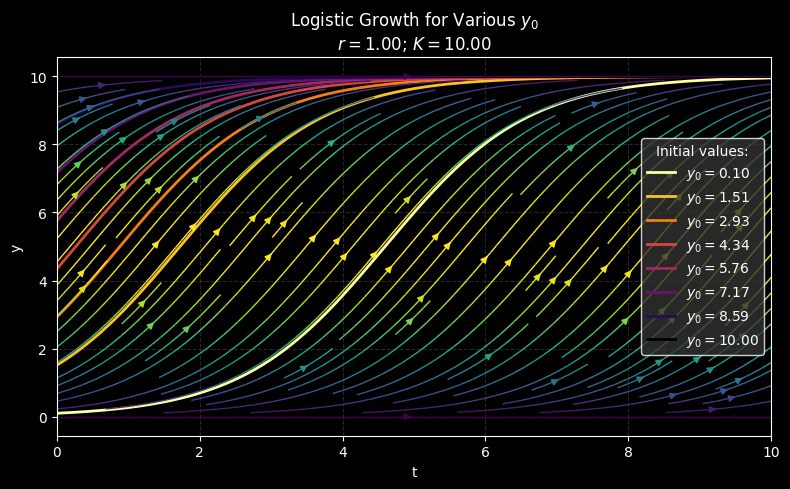

In [4]:
# Parameters
r = 1.0
K = 10.0
t_span = [0, 10]

# Initial conditions
y0_list = np.linspace(0.1, K, 8)

# --- Plot ---
plt.style.use("dark_background")
cmap = plt.get_cmap("viridis")
cmap2 = plt.get_cmap("inferno_r")
colors = cmap2(np.linspace(0, 1, len(y0_list)))

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title((
    "Logistic Growth for Various $y_0$\n" 
    f"$r={r:.2f}$; $K={K:.2f}$"
))
ax.set_xlabel("t")
ax.set_ylabel("y")

for y0, c in zip(y0_list, colors):
    sol = si.solve_ivp(logistic_eq, t_span, [y0], args=(r, K), dense_output=True)
    t_plot = np.linspace(t_span[0], t_span[1], 200)
    y_plot = sol.sol(t_plot)[0]

    ax.plot(t_plot, y_plot, label=f"$y_0={y0:.2f}$", linewidth=2, color=c)

# --- Grid for the vector field ---
t_vals = np.linspace(t_span[0], t_span[1], 20)
y_vals = np.linspace(0, K, 20)
T, Y = np.meshgrid(t_vals, y_vals)
dY = logistic_eq(T, Y, r, K)
dT = np.ones_like(dY)

# Normalize vectors
M = np.hypot(dT, dY)
U = np.divide(dT, M, out=np.zeros_like(dT), where=(M != 0))
V = np.divide(dY, M, out=np.zeros_like(dT), where=(M != 0))

# Color by slope magnitude and plot vector field
norm = mcolors.Normalize(vmin=np.min(dY), vmax=np.max(dY))

ax.streamplot(
    T, Y,
    U, V,
    color=dY,
    cmap=cmap,
    norm=norm,
    density=1.5,
    linewidth=1
)


ax.legend(
    title=f"Initial values:", facecolor="#333333", edgecolor="white", labelcolor="white"
)
ax.grid(color="gray", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

## Predator-Prey Model

The Lotka-Volterra equations, commonly used to model predator-prey dynamics, are given by:

$$
\dot{x} = \alpha\ x - \beta\ x\ y \quad \text{Prey}
$$

$$
\dot{y} = \delta\ x\ y - \gamma\ y \quad \text{Predator}
$$

We can define a state vector $\vec{v}$ to represent the current state of our system:

$$
\vec{v} =
\begin{bmatrix}
x \\
y
\end{bmatrix}
$$

Consequently, the rate of change of the state vector can be expressed as:

$$
\dot{\vec{v}} =
\begin{bmatrix}
\dot{x} \\
\dot{y}
\end{bmatrix}
$$

In [5]:
@latexify.function
def predator_prey(t, v, alpha, beta, delta, gamma):
    prey = v[0]
    predator = v[1]
    dxdt = alpha * prey - beta * prey * predator
    dydt = delta * prey * predator - gamma * predator
    
    return [dxdt, dydt]

predator_prey

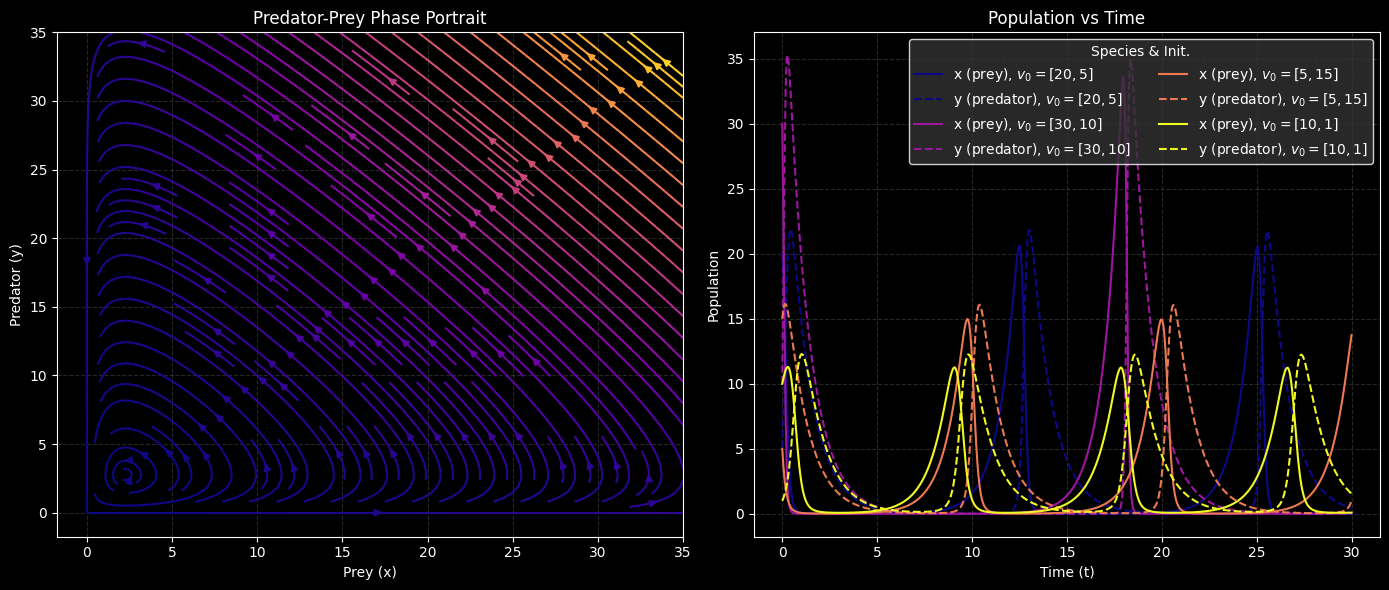

In [6]:
# Parameters and time span
alpha, beta, delta, gamma = 1.1, 0.4, 0.4, 0.9
t_span = [0, 30]
t_vals = np.linspace(t_span[0], t_span[1], 500)

# Initial states: [prey, predator]
v0_list = [
    [20, 5],
    [30, 10],
    [5, 15],
    [10, 1],
]

# --- Plot ---
plt.style.use("dark_background")

cmap = plt.get_cmap("plasma")
colors = cmap(np.linspace(0, 1, len(v0_list)))

ax_phase: Axes
ax_time: Axes
fig, (ax_phase, ax_time) = plt.subplots(1, 2, figsize=(14, 6))

# Build grid for vector field
x_max = 35
y_max = 35
x_vals = np.linspace(0, x_max, 20)
y_vals = np.linspace(0, y_max, 20)
X, Y = np.meshgrid(x_vals, y_vals)

# Compute derivatives on grid
dXdT, dYdT = predator_prey([], [X, Y], alpha, beta, delta, gamma)

# Normalize arrows
M = np.hypot(dXdT, dYdT)
U = np.divide(dXdT, M, out=np.zeros_like(dXdT), where=(M != 0))
V = np.divide(dYdT, M, out=np.zeros_like(dYdT), where=(M != 0))

# --- Phase Trajectory plot ---
norm = mcolors.Normalize(vmin=np.min(M), vmax=np.max(M))
# ax_phase.quiver(X, Y, U, V, M, cmap=cmap, norm=norm, pivot="mid", alpha=0.8, scale=40)
ax_phase.streamplot(X, Y, dXdT, dYdT, color=M, density=1.5, cmap=cmap, norm=norm, linewidth=1.5)


for v0, color in zip(v0_list, colors):
    sol = si.solve_ivp(
        predator_prey, t_span, v0, args=(alpha, beta, delta, gamma), dense_output=True
    )
    XY = sol.sol(t_vals)
    # --- Phase Space ---
    # ax_phase.plot(XY[0], XY[1], color=color, linewidth=2, label=f"$v_0$ = {v0}")
    # ax_phase.plot(v0[0], v0[1], "o", color=color, markersize=6, markeredgecolor="white")
    # --- Time plot ---
    ax_time.plot(t_vals, XY[0], "-", label=f"x (prey), $v_0={v0}$", color=color)
    ax_time.plot(t_vals, XY[1], "--", label=f"y (predator), $v_0={v0}$", color=color)

# --- Legends Phase Space ---
ax_phase.set_title("Predator-Prey Phase Portrait")
ax_phase.set_xlabel("Prey (x)")
ax_phase.set_ylabel("Predator (y)")
# ax_phase.legend(
#     title="Initial States",
#     facecolor="#333333",
#     edgecolor="white",
# )
ax_phase.grid(color="gray", linestyle="--", alpha=0.3)
# --- Legends Time Series --- 
ax_time.set_title("Population vs Time")
ax_time.set_xlabel("Time (t)")
ax_time.set_ylabel("Population")
ax_time.legend(title="Species & Init.", facecolor="#333333", edgecolor="white", ncol=2)
ax_time.grid(color="gray", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

## Damped Pendulum

This is a second-order differential equation describing the motion of a pendulum with damping (due to air resistance):

$$
\frac{d^2 \theta}{dt^2} + b\ \frac{d\theta}{dt} + c\ \sin(\theta) = 0
$$

The ODE solver we are currently utilizing, `solve_ivp`, is designed for first-order differential equations. Therefore, we must devise a method for the solver to handle this second-order equation. Let us attempt to vectorize our equation.

First, let's define:

$$
\dot{\theta} = \rho
$$

This will represent the state corresponding to our variable $\theta$. Now, by differentiating this, we obtain:

$$
\dot{\rho} = \ddot{\theta}
$$

With this new understanding, we can substitute into our main equation to arrive at a vector form that our equation solver can accept:

$$
\ddot{\theta} + b\ \dot{\theta} + c\ \sin(\theta) = 0 \quad \implies \quad
\dot{\rho} = - b\ \rho - c\ \sin(\theta)
$$

Thus, we can express the system as:

$$
\begin{bmatrix}
\dot{\theta}\\
\dot{\rho}
\end{bmatrix}
= \begin{bmatrix}
\rho \\
-b\ \rho - c\ \sin(\theta)
\end{bmatrix}
$$

In [7]:
@latexify.function
def damped_pendulum(t, y, b, c):
    theta = y[0]
    rho = y[1]
    return [rho, -b * rho - c * np.sin(theta)]

damped_pendulum

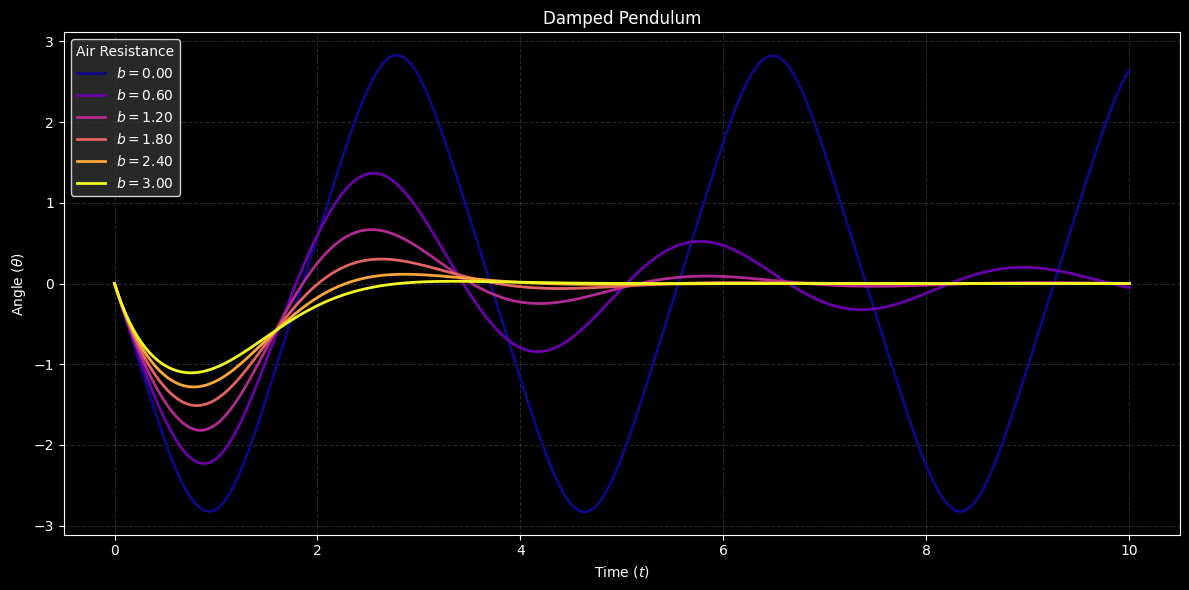

In [8]:
# Parameters
c = 4
b = np.linspace(0, 3, 6)
t_span = [0, 10]
t_vals = np.linspace(t_span[0], t_span[1], 500)
#  Initial conditions 90 degrees and starting velocity 0
y0 = [np.pi/2, 0]

# --- Plot ---
plt.style.use("dark_background")

cmap = plt.get_cmap("plasma")
colors = cmap(np.linspace(0, 1, len(b)))

fig, ax = plt.subplots(figsize=(12, 6))

for b_val, color in zip(b, colors):
    sol = si.solve_ivp(damped_pendulum, t_span, y0, args=(b_val, c), dense_output=True)
    XY = sol.sol(t_vals)
    # Only interested in values of theta
    ax.plot(t_vals, XY[1], color=color, linewidth=2, label=f"$b={b_val:.2f}$")
    
ax.set_title("Damped Pendulum")
ax.set_xlabel(f"Time ($t$)")
ax.set_ylabel(fr"Angle ($\theta$)")
ax.legend(
    title="Air Resistance",
    facecolor="#333333",
    edgecolor="white",
)
ax.grid(color="gray", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## Neural ODE Cell

Let us consider a toy example to illustrate our objective. This example will not involve training, but rather focus on solving a very simple case of a Neural Ordinary Differential Equation (Neural ODE), specifically utilizing a single neural network layer followed by an activation function:

$$
\frac{d \vec{y}}{dt} = f(\vec{y},\ \theta) = \tanh \left( W \cdot \vec{y} + \vec{b} \right)
$$

As this is a toy example, we will confine our scope to two dimensions to facilitate visualization.

In [9]:
@latexify.function
def neural_ode_layer(t, y, W: np.ndarray, b: np.ndarray):
    return np.tanh(np.dot(W, y) + b)

neural_ode_layer

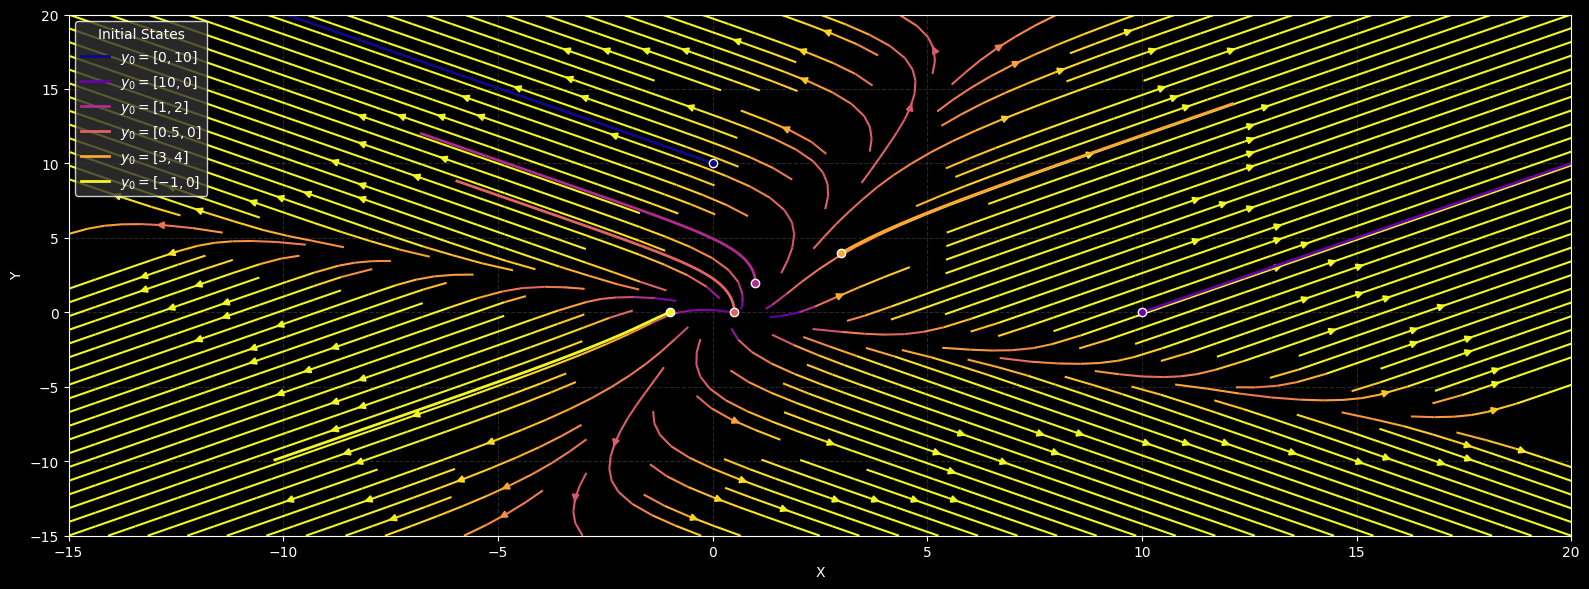

In [10]:
# --- Parameters ---
#   Creating a random weight matrix 
np.random.seed(42)
W = np.random.randn(2, 2)
b = np.random.randn(2)

t_span = [0, 10]
t_vals = np.linspace(t_span[0], t_span[1], 500)
y0_list = [[0, 10], [10, 0], [1, 2], [0.5, 0], [3, 4], [-1,0]]

# --- Plot ---
plt.style.use("dark_background")
cmap = plt.get_cmap("plasma")
# plt.style.use("classic")
# cmap = plt.get_cmap("inferno_r")
colors = cmap(np.linspace(0, 1, len(y0_list)))

fig, ax = plt.subplots(figsize=(16, 6))

#   Grid for the vector field
x_min, x_max = -15, 20
y_min, y_max = -15, 20
x_vals = np.linspace(x_min, x_max, 30)
y_vals = np.linspace(y_min, y_max, 30)
X, Y = np.meshgrid(x_vals, y_vals)
xy_pairs = np.stack([X.flatten(), Y.flatten()], axis=1)

derivatives = np.apply_along_axis(
    lambda y_slice: neural_ode_layer(0, y_slice, W, b), axis=1, arr=xy_pairs
)

dxdt = derivatives[:, 0].reshape(X.shape)
dydt = derivatives[:, 1].reshape(Y.shape)

M = np.hypot(dxdt, dydt)
U = np.divide(dxdt, M, out=np.zeros_like(dxdt), where=(M != 0))
V = np.divide(dydt, M, out=np.zeros_like(dydt), where=(M != 0))

norm = mcolors.Normalize(vmin=np.min(M), vmax=np.max(M))
ax.streamplot(
    X,           # The X grid coordinates
    Y,           # The Y grid coordinates
    dxdt,        # The x-component of the vector field
    dydt,        # The y-component of the vector field
    color=M,     # Color the lines by magnitude (speed)
    density=1.3, # Controls how crowded the lines are
    linewidth=1.5, # Controls line thickness
    cmap=cmap,   # The colormap to use for the speed
    norm=norm
)


#   Trajectory plot
for y0, color in zip(y0_list, colors):
    sol = si.solve_ivp(neural_ode_layer, t_span, y0, args=(W, b), dense_output=True)
    XY = sol.sol(t_vals)
    ax.plot(XY[0], XY[1], color=color, linewidth=2, label=f"$y_0 = {y0}$")
    ax.plot(y0[0], y0[1], "o", color=color, markersize=6, markeredgecolor="white")

# --- Legends---
# ax.set_title("Neural ODE One Layer")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend(
    title="Initial States",
    facecolor="#333333",
    edgecolor="white",
)
ax.grid(color="gray", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


## Training Neural ODE Toy Example: Predator-Prey

Let us utilize our previously discussed predator-prey model to train the most rudimentary Neural Ordinary Differential Equation (Neural ODE). We will generate a simple dataset consisting of $x$ and $y$ values within the time range of $0$ to $\tau$. Let us represent the state vector as $\vec{v} = (x, y)$. The input to our model will be $\vec{v}(0)$, and the desired output should be $\vec{v}(\tau)$.

In [11]:
@latexify.function
def predator_prey(t, v, alpha, beta, delta, gamma):
    prey, predator = v
    d_prey_dt = alpha * prey - beta * prey * predator
    d_predator_dt = delta * prey * predator - gamma * predator
    return [d_prey_dt, d_predator_dt]

predator_prey

To train our model, we first need to generate a synthetic dataset. This function, `get_predator_prey_dataset`, will create a grid of initial conditions $(x_0, y_0)$ representing different starting populations for prey and predators.

For each initial condition, it uses `scipy.integrate.solve_ivp` to solve the Lotka-Volterra equations forward in time from $t=0$ to $t=\tau$. The initial state serves as the input (`X`) to our model, and the final state at $t=\tau$ serves as the ground truth target (`Y`). This process simulates having a set of observations where we know the starting and ending states of a system and want to learn the underlying dynamics that connect them.

The function also includes an option to convert the resulting NumPy arrays to PyTorch tensors for easy integration with deep learning frameworks.

In [12]:
def get_predator_prey_dataset(
    alpha: float = 1.1,
    beta: float = 0.4,
    delta: float = 0.4,
    gamma: float = 0.9,
    t_span: list[float] = [0, 1.0],
    on_torch: bool = False,
    prey_min: float = 0.5,
    prey_max: float = 10,
    predator_min: float = 0.5,
    predator_max: float = 10,
    n: int = 10,
):
    prey_values = np.linspace(prey_min, prey_max, n)
    predator_values = np.linspace(predator_min, predator_max, n)

    prey_grid, predator_grid = np.meshgrid(prey_values, predator_values)
    X = np.stack([prey_grid.flatten(), predator_grid.flatten()], axis=1)

    Y_list = []
    for x0 in X:
        sol = si.solve_ivp(predator_prey, t_span, x0, args=(alpha, beta, delta, gamma))
        final_state = sol.y[:, -1]
        Y_list.append(final_state)

    Y = np.array(Y_list)
    if not on_torch:
        return X, Y

    return torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(
        Y, dtype=torch.float32
    ).to(device)

In [13]:
@latexify.function
def neural_ode_layer_act(t, y, W: np.ndarray, b: np.ndarray):
    return np.tanh(np.dot(W, y) + b)

@latexify.function
def neural_ode_layer(t, y, W: np.ndarray, b: np.ndarray):
    return np.dot(W, y) + b

Now, we define the core of our Neural ODE: the function $f$ that represents the learned dynamics. Since the Lotka-Volterra system is non-linear, a simple linear transformation $\dot{y} = W \cdot y + b$ is unlikely to capture its behavior effectively.

Therefore, we introduce non-linearity by wrapping the linear layer with a hyperbolic tangent (`tanh`) activation function. This creates a more expressive model capable of learning complex, non-linear dynamics. We define both versions here: `neural_ode_layer` for the linear case and `neural_ode_layer_act` for the non-linear case, allowing us to experiment with both.

In [14]:
class NODE:
    def __init__(self, activation_function: bool = False) -> None:
        self.W = np.random.randn(2, 2) * 0.1
        self.b = np.random.randn(2) * 0.1
        self.vW = np.zeros_like(self.W)
        self.vb = np.zeros_like(self.b)

        self.activation_function = activation_function
        if activation_function:
            self.model = neural_ode_layer_act
        else:
            self.model = neural_ode_layer
        self.t_span = [0, 1.0]

    def forward(self, X: np.ndarray) -> np.ndarray:
        pred_list = []
        for x0 in X:
            sol = si.solve_ivp(
                self.model, self.t_span, x0, args=(self.W, self.b), rtol=1e-6, atol=1e-8
            )
            final_state = sol.y[:, -1]
            pred_list.append(final_state)
        return np.array(pred_list)

    def get_loss_fn(self):
        def loss_fn(pred, y_true):
            return np.mean((pred - y_true) ** 2) / 2

        return loss_fn

    def step(self, lr, dL_dW, dL_db, beta=0.9):
        # Update velocities (the "first moment")
        self.vW = beta * self.vW + (1 - beta) * dL_dW
        self.vb = beta * self.vb + (1 - beta) * dL_db

        # Update parameters with the velocity
        self.W -= lr * self.vW
        self.b -= lr * self.vb

    def get_grad(self, X_true: np.ndarray, Y_true: np.ndarray):
        Y_pred = self.forward(X_true)
        num_points = len(X_true)

        dLoss_dY_pred = (Y_pred - Y_true) / num_points

        # This is the single, non-batched dynamics function for the augmented state
        def augmented_dynamics(t, state, W, b):
            z = state[0:2]
            a = state[2:4]

            if self.activation_function:
                pre_activation = W @ z + b
                f_z = np.tanh(pre_activation)
                d_tanh_d_pre = 1 - f_z**2

                df_dz = np.diag(d_tanh_d_pre) @ W
                dz_dt = f_z
                da_dt = -a @ df_dz
                dLdW_dt = np.outer(a * d_tanh_d_pre, z)
                dLdb_dt = a * d_tanh_d_pre

            else:
                df_dz = W
                dz_dt = W @ z + b
                da_dt = -a @ df_dz
                dLdW_dt = np.outer(a, z)
                dLdb_dt = a

            return np.concatenate([dz_dt, da_dt, dLdW_dt.flatten(), dLdb_dt.flatten()])

        # --- Looping over each trajectory for the backward pass ---
        dL_dW = np.zeros_like(self.W)
        dL_db = np.zeros_like(self.b)

        for i in range(num_points):
            s0_aug = np.concatenate([Y_pred[i], dLoss_dY_pred[i], np.zeros(6)])

            aug_sol = si.solve_ivp(
                augmented_dynamics,
                [self.t_span[1], self.t_span[0]],  # Backward time
                s0_aug,
                args=(self.W, self.b),
                rtol=1e-6,
                atol=1e-8,
            )  # Since this is bakwards wields negative results

            final_grad_state = aug_sol.y[:, -1]
            dL_dW += final_grad_state[4:8].reshape(2, 2)
            dL_db += final_grad_state[8:10]

        return -dL_dW, -dL_db, Y_pred  # Negate the result from backwards in time

    def visualize(self):
        plt.style.use("dark_background")
        cmap = plt.get_cmap("plasma")
        fig, ax = plt.subplots(figsize=(6, 6))
        # --- ---
        prey_values = np.linspace(-10, 10, 10)
        predator_values = np.linspace(-10, 10, 10)
        X, Y = np.meshgrid(prey_values, predator_values)
        xy_pairs = np.stack([X.flatten(), Y.flatten()], axis=1)

        if self.activation_function:
            derivatives = np.apply_along_axis(
                lambda y_slice: neural_ode_layer_act(0, y_slice, self.W, self.b),
                axis=1,
                arr=xy_pairs,
            )
        else:
            derivatives = np.apply_along_axis(
                lambda y_slice: neural_ode_layer(0, y_slice, self.W, self.b),
                axis=1,
                arr=xy_pairs,
            )

        dxdt = derivatives[:, 0].reshape(X.shape)
        dydt = derivatives[:, 1].reshape(Y.shape)

        M = np.hypot(dxdt, dydt)
        norm = mcolors.Normalize(vmin=np.min(M), vmax=np.max(M))

        ax.streamplot(
            X,  # The X grid coordinates
            Y,  # The Y grid coordinates
            dxdt,  # The x-component of the vector field
            dydt,  # The y-component of the vector field
            color=M,  # Color the lines by magnitude (speed)
            density=1.5,  # Controls how crowded the lines are
            linewidth=1,  # Controls line thickness
            cmap=cmap,  # The colormap to use for the speed
            norm=norm,
        )
        # --- Legends---
        ax.set_title("Neural ODE One Layer")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.grid(color="gray", linestyle="--", alpha=0.3)
        ax.set_aspect("equal")
        plt.tight_layout()
        plt.show()

Here, we define the `NODE` class, which encapsulates all the logic for our from-scratch model.

**Key Components:**
*   **`__init__`**: Initializes the model's parameters—a weight matrix `W` and a bias vector `b`—with small random values. It also initializes velocity terms `vW` and `vb` for use with momentum-based optimization. A flag allows us to switch between the linear and non-linear (with `tanh`) versions of the dynamics.
*   **`forward`**: This method performs the forward pass. For each initial state `x0` in a batch, it integrates the learned dynamics `self.model` forward in time using an ODE solver to produce a final state prediction.
*   **`get_loss_fn`**: Returns a simple Mean Squared Error (MSE) loss function to measure the difference between the predicted final states and the true final states.
*   **`step`**: Implements a basic momentum optimizer. Instead of vanilla gradient descent, this helps to smooth the learning process by updating parameters using a moving average of the gradients.
*   **`get_grad`**: This is the most critical part of the implementation. It calculates the gradients of the loss with respect to the model parameters `W` and `b` using the **adjoint sensitivity method**.
    *   It first computes the gradient of the loss with respect to the output, $\frac{\partial L}{\partial \vec{z}(t_1)}$.
    *   It then defines an `augmented_dynamics` function, which combines the original forward dynamics, the adjoint dynamics, and the gradient dynamics into a single system.
    *   Finally, it solves this augmented system backward in time (from $t_1$ to $t_0$) to efficiently compute the gradients $\frac{dL}{dW}$ and $\frac{dL}{db}$ without storing the entire forward trajectory in memory.
*   **`visualize`**: A helper function to plot the vector field learned by the model, allowing us to qualitatively assess how well it has captured the system's dynamics.

In [15]:
def train_model(model: NODE, lr: float, epoches: int, X_true, Y_true):
    loss_fn = model.get_loss_fn()
    pred = model.forward(X_true)
    loss = loss_fn(pred, Y_true)
    print(f"Model loss Before training: {loss:.4f}")
    model.visualize()

    print("--- Starting training ---")
    for epoche in range(1, epoches + 1):
        dL_dW, dL_db, Y_pred = model.get_grad(X_true, Y_true)
        model.step(lr, dL_dW, dL_db)
        
        if epoche % ((epoches + 1 ) // 4) == 0:
            loss = loss_fn(Y_pred, Y_true)
            print(f"Epoche: {epoche:_}/{epoches:_}\nLoss: {loss:.4f}")
    model.visualize()

This `train_model` function orchestrates the entire training loop. It takes an instance of our `NODE` model, a learning rate, the number of epochs, and the training data as input.

The process is as follows:
1.  It begins by calculating and printing the initial loss and visualizing the randomly initialized vector field to establish a baseline.
2.  It then iterates for the specified number of epochs. In each epoch:
    a.  It calls `model.get_grad()` to perform both a forward pass (to get predictions) and a backward pass (using the adjoint method to get gradients).
    b.  It calls `model.step()` to update the model's parameters `W` and `b` using the computed gradients and the momentum optimizer.
3.  Periodically, it prints the current loss to monitor training progress.
4.  After training is complete, it visualizes the final learned vector field, which should now resemble the true dynamics of the predator-prey system.

In [16]:
def calculate_tolerance_accuracy(y_pred, y_true, tolerance):
    """
    Calculates the percentage of predictions that fall within a given
    Euclidean distance (tolerance) of their true values.
    """
    # Calculate the Euclidean distance for all points at once
    # np.linalg.norm with axis=1 is perfect for this
    distances = np.linalg.norm(y_pred - y_true, axis=1)
    
    # Check which distances are within the tolerance
    # This creates a boolean array (True for hits, False for misses)
    hits = distances <= tolerance
    
    # The mean of a boolean array gives the percentage of True values
    accuracy = np.mean(hits)
    
    return accuracy

While Mean Squared Error (MSE) is a useful loss metric for training, it can be difficult to interpret in terms of practical performance. A more intuitive metric for this regression task is "tolerance-based accuracy."

This function, `calculate_tolerance_accuracy`, measures the model's performance by calculating the percentage of predicted final states that land within a specified Euclidean distance (the `tolerance`) of their true target positions. For example, an accuracy of 95% with a tolerance of 0.1 means that 95% of the model's predictions were less than 0.1 units away from the actual final state. This provides a clear and interpretable measure of how well our model has learned to predict the system's evolution.

### Experiment 1: Training a Linear NODE

We begin our experiments with the simplest possible case: a linear Neural ODE. In this model, the learned dynamics function is a simple linear transformation, $f(\vec{y}, \theta) = W \cdot \vec{y} + \vec{b}$.

While we know the true predator-prey system is non-linear, this experiment serves as a crucial baseline. It will help us understand the fundamental training process and establish a performance benchmark. We expect that this model will struggle to capture the complex, cyclical nature of the Lotka-Volterra equations, but it will demonstrate whether our from-scratch adjoint implementation is working correctly.

Let's initialize the model without an activation function and train it for 400 epochs.

In [17]:
model_lin = NODE()

Model loss Before training: 14.6042


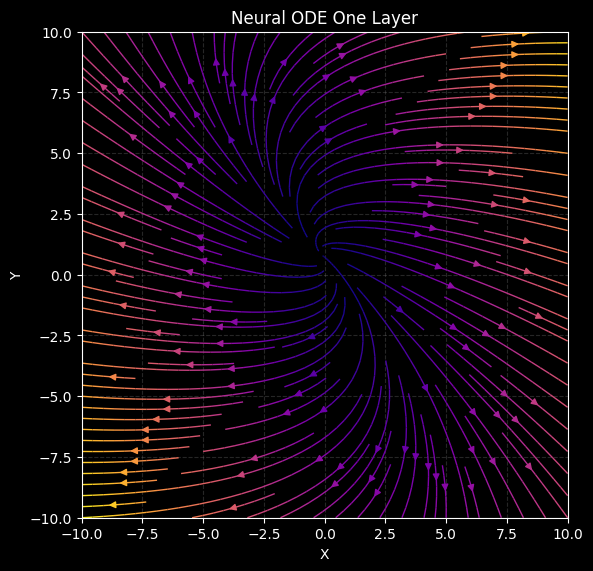

--- Starting training ---
Epoche: 100/400
Loss: 1.1032
Epoche: 200/400
Loss: 1.0130
Epoche: 300/400
Loss: 0.9548
Epoche: 400/400
Loss: 0.9096


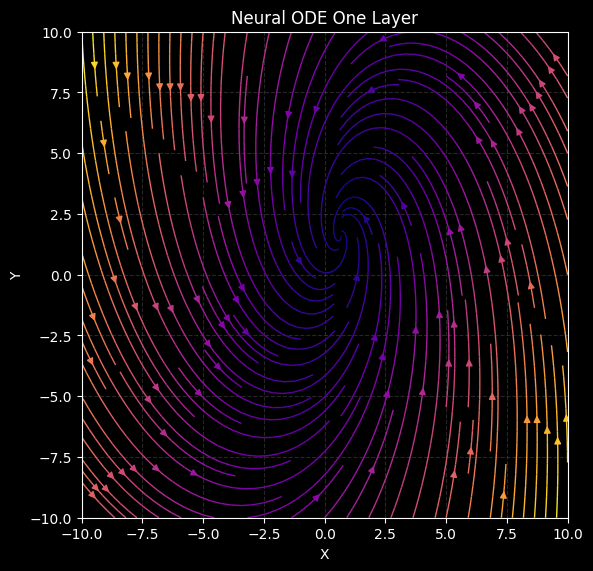

In [18]:
X_true, Y_true = get_predator_prey_dataset()
train_model(model_lin, lr=1e-2, epoches=400, X_true=X_true, Y_true=Y_true)

In [19]:
Y_pred = model_lin.forward(X_true)
accuracy = calculate_tolerance_accuracy(Y_pred, Y_true, 0.5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 19.00%


### Experiment 2: Introducing Non-Linearity with `tanh`

Having established a baseline, we now introduce a non-linear activation function to our NODE. The dynamics are now governed by $f(\vec{y}, \theta) = \tanh(W \cdot \vec{y} + \vec{b})$.

The `tanh` function is well-suited for this task as it can create bounded, complex vector fields. This added expressive power should, in theory, allow the model to learn the cyclical patterns of the predator-prey system. We will use the same training setup as before and compare the final loss, accuracy, and learned vector field to our linear baseline.

In [20]:
model_act = NODE(activation_function=True)

Model loss Before training: 9.9018


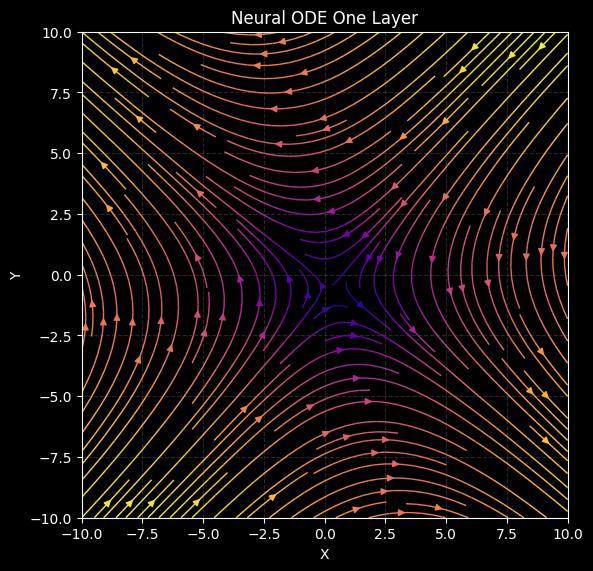

--- Starting training ---
Epoche: 100/400
Loss: 7.5008
Epoche: 200/400
Loss: 7.4859
Epoche: 300/400
Loss: 7.4792
Epoche: 400/400
Loss: 7.4728


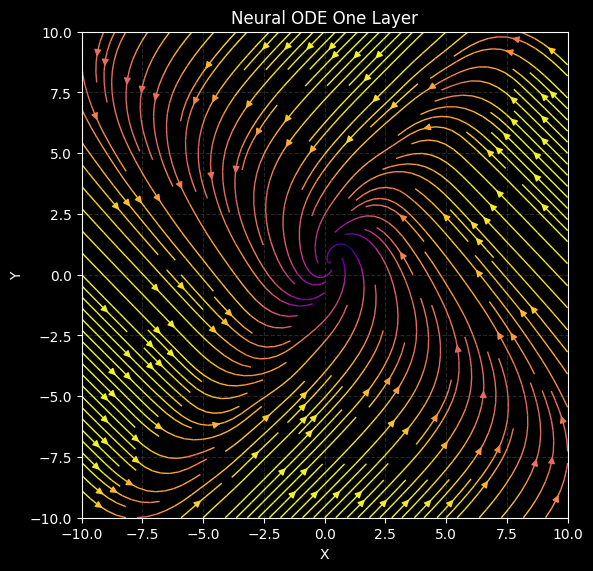

In [21]:
X_true, Y_true = get_predator_prey_dataset()
train_model(model_act, lr=1e-2, epoches=400, X_true=X_true, Y_true=Y_true)

In [22]:
Y_pred = model_act.forward(X_true)
accuracy = calculate_tolerance_accuracy(Y_pred, Y_true, 0.5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 2.00%


## A Baseline for Comparison: The Standard MLP Approach

Before we implement a Neural ODE using modern libraries, it's essential to establish a strong baseline. What if we ignored the continuous-time nature of the problem entirely and treated it as a simple regression task?

Here, we define a standard **Multi-Layer Perceptron (MLP)**. This model does not involve an ODE solver. Instead, it attempts to directly learn a mapping from an initial state $\vec{v}(0)$ to a final state $\vec{v}(\tau)$. It's a "black box" that learns the *result* of the time evolution, not the *process* itself.

The `SimpleMLP` class is a standard PyTorch `nn.Module`. Its visualization function is slightly different: instead of plotting the learned vector field (the instantaneous velocity $\frac{d\vec{y}}{dt}$), it plots the *displacement field*, which shows the total change from the initial to the final state ($\vec{v}(\tau) - \vec{v}(0)$).

By training this MLP, we can see how a conventional deep learning model performs on this task. This will provide a crucial point of comparison for both accuracy and computational efficiency against the more complex Neural ODE models.


In [23]:
class SimpleMLP(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
        )
        # self.model = nn.Linear(2, 2)

    def forward(self, x):
        return self.model(x.to(device))

    def get_optimizer(self, lr: float, weight_decay: float = 0):
        return torch.optim.SGD(self.parameters(), lr=lr, weight_decay=weight_decay)

    def get_loss_fn(self):
        return nn.L1Loss()

    def visualize(
        self,
        X_min: float = -10,
        X_max: float = 10,
        Y_min: float = -10,
        Y_max: float = 10,
    ):
        device = next(self.parameters()).device

        plt.style.use("dark_background")
        cmap = plt.get_cmap("plasma")
        fig, ax = plt.subplots(figsize=(6, 6))

        # 1. Create grid on CPU
        X, Y = np.meshgrid(np.linspace(X_min, X_max, 20), np.linspace(Y_min, Y_max, 20))
        grid_points_cpu = torch.tensor(
            np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32
        )

        # 2. Move data TO GPU for inference
        grid_points_gpu = grid_points_cpu.to(device)

        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation for speed
            # This computation now happens on the GPU
            Y_pred_grid_gpu = self.model(grid_points_gpu)

        # 3. Move result BACK to CPU for plotting
        Y_pred_grid_cpu = Y_pred_grid_gpu.cpu()

        # The rest of your code can now work with the CPU tensors
        displacement_vectors = Y_pred_grid_cpu - grid_points_cpu

        dx_discrete = displacement_vectors[:, 0].reshape(X.shape)
        dy_discrete = displacement_vectors[:, 1].reshape(Y.shape)

        dx = dx_discrete.detach().numpy()
        dy = dy_discrete.detach().numpy()
        M = np.hypot(dx, dy)
        norm = mcolors.Normalize(vmin=np.min(M), vmax=np.max(M))

        ax.streamplot(
            X, Y, dx, dy, color=M, cmap=cmap, norm=norm, linewidth=1, density=1.2
        )

        ax.set_title("MLP Model Displacement Field")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.grid(color="gray", linestyle="--", alpha=0.3)
        ax.set_aspect("equal")
        plt.tight_layout()
        plt.show()
        
        self.to(device)

In [24]:
def train_torch_model(model: SimpleMLP, lr: float, epoches: int, X, Y, weight_decay: float=0):
    loss_fn = model.get_loss_fn()
    logits = model(X)
    initial_loss = loss_fn(logits, Y)
    print(f"Initial loss: {initial_loss.cpu():.4f}")
    model.visualize()
    
    optimizer = model.get_optimizer(lr, weight_decay)
    model.train()
    current_loss = 0
    print("--- Starting training ---")
    for epoche in range(1, epoches + 1):
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss: torch.Tensor = loss_fn(logits, Y)
        loss.backward()
        optimizer.step() 
        current_loss += loss.item()
        
        if epoche % ((epoches + 1 ) // 4) == 0:
            print(f"Epoche: {epoche:_}/{epoches:_}\nLoss: {loss:.4f}")
            
    model.visualize()
    

### 3.1. Training the MLP with `tanh`

We will first train our MLP using the `tanh` activation function, which is a common choice for modeling dynamical systems due to its smooth, bounded nature. We will train the model for a large number of epochs to allow it to converge fully and then evaluate its accuracy on both the training distribution and an out-of-distribution test set.

In [25]:
model_torch = SimpleMLP().to(device)

Initial loss: 3.7130


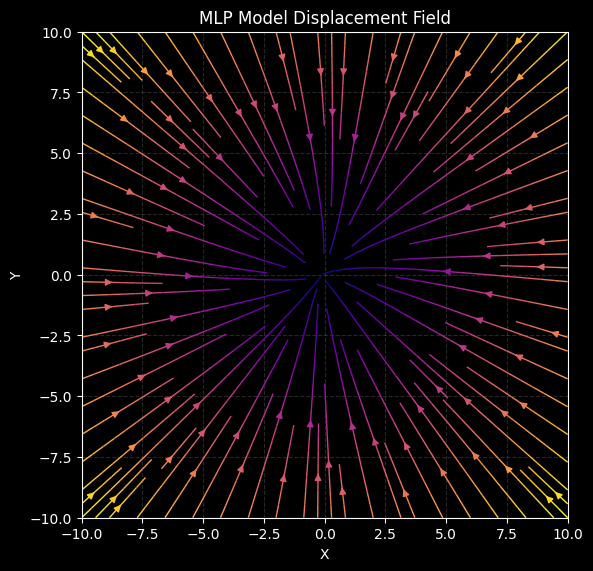

--- Starting training ---
Epoche: 100_000/400_000
Loss: 0.0991
Epoche: 200_000/400_000
Loss: 0.0439
Epoche: 300_000/400_000
Loss: 0.0400
Epoche: 400_000/400_000
Loss: 0.0256


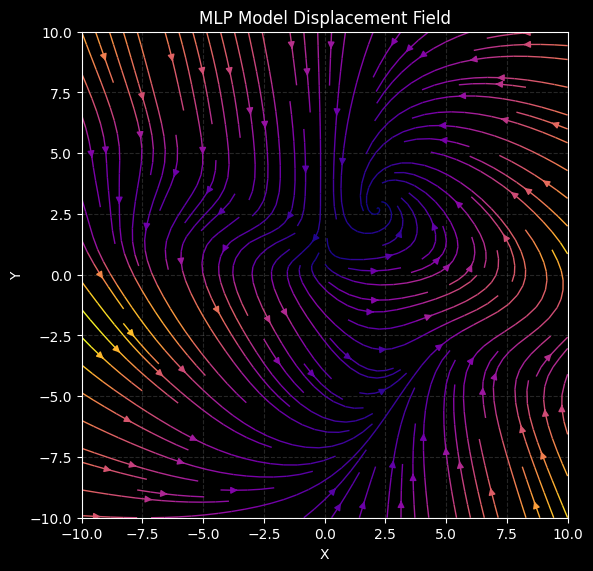

In [26]:
X_true_torch, Y_true_torch = get_predator_prey_dataset(on_torch=True)
train_torch_model(model_torch, lr=1e-3, epoches=400_000, X=X_true_torch, Y=Y_true_torch, weight_decay=1e-4)

In [27]:
model_torch.eval()
with torch.no_grad():
    Y_pred: torch.Tensor = model_torch(X_true_torch)
    
accuracy = calculate_tolerance_accuracy(Y_pred.cpu().detach().numpy(), Y_true_torch.cpu().detach().numpy(), 0.5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 100.00%


In [28]:
X_true_torch, Y_true_torch = get_predator_prey_dataset(
    on_torch=True, 
    n=50, 
    prey_min=10,
    prey_max=15,
    predator_min=10, 
    predator_max=15,
)
model_torch.eval()
with torch.no_grad():
    Y_pred: torch.Tensor = model_torch(X_true_torch)
    
accuracy = calculate_tolerance_accuracy(Y_pred.cpu().detach().numpy(), Y_true_torch.cpu().detach().numpy(), 0.5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 18.92%


### 3.2. Training the MLP with `ReLU`

Next, we swap the activation function to the more commonly used Rectified Linear Unit (`ReLU`). While `ReLU` is the standard in many deep learning domains, its non-smooth, unbounded nature can sometimes make it less suitable for learning the continuous flows of physical systems. This experiment will test that assumption and compare its performance directly against the `tanh` model.

In [29]:
model_torch_2 = SimpleMLP()
model_torch_2.model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
)
model_torch_2.to(device)

SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

Initial loss: 3.8672


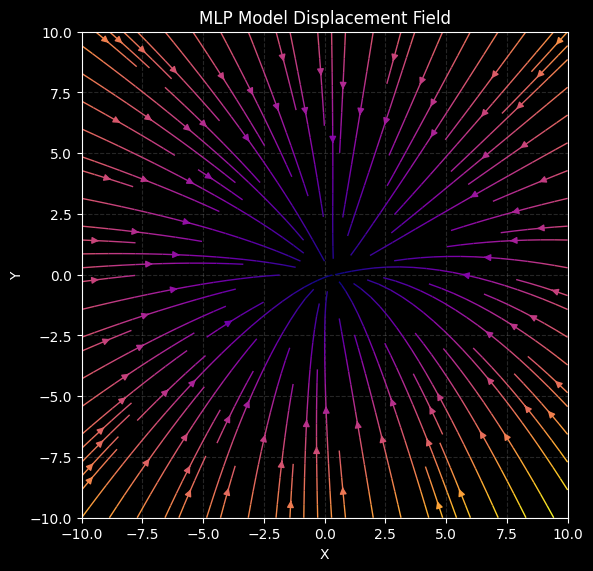

--- Starting training ---
Epoche: 100_000/400_000
Loss: 0.1790
Epoche: 200_000/400_000
Loss: 0.1013
Epoche: 300_000/400_000
Loss: 0.0853
Epoche: 400_000/400_000
Loss: 0.0549


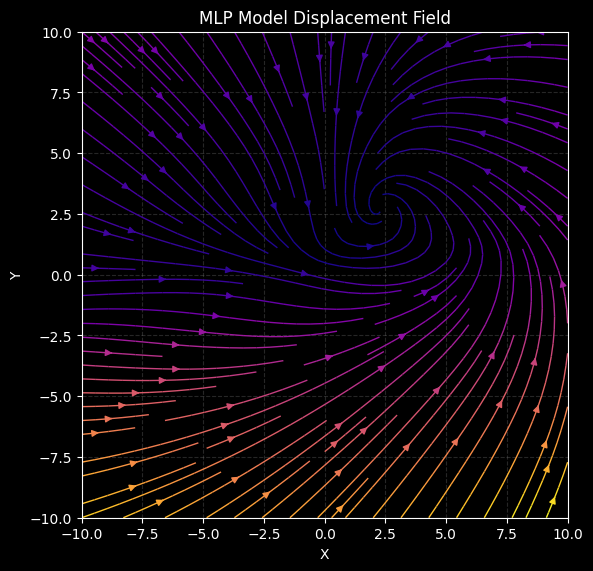

In [30]:
X_true_torch, Y_true_torch = get_predator_prey_dataset(on_torch=True)
train_torch_model(model_torch_2, lr=1e-3, epoches=400_000, X=X_true_torch, Y=Y_true_torch, weight_decay=1e-4)

In [31]:
model_torch_2.eval()
with torch.no_grad():
    Y_pred: torch.Tensor = model_torch_2(X_true_torch)
    
accuracy = calculate_tolerance_accuracy(Y_pred.cpu().detach().numpy(), Y_true_torch.cpu().detach().numpy(), 0.5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 100.00%


In [32]:
X_true_torch, Y_true_torch = get_predator_prey_dataset(
    on_torch=True, 
    n=50, 
    prey_min=10,
    prey_max=15,
    predator_min=10, 
    predator_max=15,
)
model_torch_2.eval()
with torch.no_grad():
    Y_pred: torch.Tensor = model_torch_2(X_true_torch)
    
accuracy = calculate_tolerance_accuracy(Y_pred.cpu().detach().numpy(), Y_true_torch.cpu().detach().numpy(), 0.5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 14.24%


## The Modern Workflow: Implementing a NODE with `torchdiffeq`

Having built a NODE from scratch and established an MLP baseline, we now turn to the modern, standard approach for implementing Neural ODEs in PyTorch: the `torchdiffeq` library. This library provides a highly optimized, numerically stable, and easy-to-use implementation of the adjoint method and various ODE solvers, abstracting away the complex manual gradient calculations we performed earlier.

The implementation is now split into two main components:

1.  **`ODEFunc`**: An `nn.Module` that defines the neural network for the learned dynamics function, $f(\vec{y}, t, \theta)$. This is the "heart" of the NODE, equivalent to our previous `neural_ode_layer_act` function.
2.  **`NeuralODE`**: A wrapper module that takes the `ODEFunc` and handles the integration process by calling `torchdiffeq.odeint`. The forward pass of this module solves the differential equation, and crucially, the backward pass automatically uses the efficient adjoint method provided by the library.

Notice how much simpler the `forward` and `backward` passes become. We no longer need to manually define the augmented state or solve the system backward in time; `torchdiffeq` and PyTorch's autograd handle all of this seamlessly. The visualization function is also updated to plot the true learned vector field by calling `self.func` directly.

This represents the canonical way to build and train Neural ODEs in practice.

In [33]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
        )
        # self.net = nn.Linear(2, 2)
        
    def forward(self, t, y):
        return self.net(y)

In [34]:
class NeuralODE(nn.Module):
    def __init__(self, func, t_span=[0.0, 1.0]):
        super(NeuralODE, self).__init__()
        self.func = func
        self.t_span = torch.tensor(t_span).to(device)  # The integration time

    def forward(self, x0, t_eval=None, rtol=1e-3, atol=1e-4):
        if t_eval == None:
            t_eval = self.t_span

        solution = odeint(self.func, x0, t_eval.to(device), rtol=rtol, atol=atol)

        # The shape of solution is (time, batch, features).
        if len(t_eval) == 2:
            return solution[1]  # Return only the final state for training-like calls
        else:
            return solution

    def get_optmizer(self, lr, weight_decay: float = 0) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

    def get_loss_fn(self):
        return nn.L1Loss()

    def visualize(
        self,
        X_min: float = -10,
        X_max: float = 10,
        Y_min: float = -10,
        Y_max: float = 10,
    ):
        plt.style.use("dark_background")
        cmap = plt.get_cmap("plasma")
        fig, ax = plt.subplots(figsize=(6, 6))

        X, Y = np.meshgrid(np.linspace(X_min, X_max, 30), np.linspace(Y_min, Y_max, 30))
        grid_points_gpu = torch.tensor(
            np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32
        ).to(device)

        # --- 2. Get the Instantaneous Velocity (The Key Change) ---
        # We put the model in evaluation mode for inference
        self.eval()
        with torch.no_grad():  # Disable gradient calculation for speed
            # Call self.func DIRECTLY. This is f(t, y), which IS the velocity.
            # We pass t=0 because our dynamics don't depend on time.
            velocity_vectors_gpu = self.func(0, grid_points_gpu)

        velocity_vectors = velocity_vectors_gpu.cpu()

        # --- 3. Reshape and Plot (no change in logic) ---
        dx_flow = velocity_vectors[:, 0].reshape(X.shape)
        dy_flow = velocity_vectors[:, 1].reshape(Y.shape)

        # Convert to NumPy for plotting
        dx = dx_flow.numpy()
        dy = dy_flow.numpy()
        M = np.hypot(dx, dy)
        norm = mcolors.Normalize(vmin=np.min(M), vmax=np.max(M))

        ax.streamplot(
            X, Y, dx, dy, color=M, cmap=cmap, norm=norm, linewidth=1, density=1.5
        )

        ax.set_title("Learned Vector Field of the Neural ODE")
        ax.set_xlabel("Prey Population")
        ax.set_ylabel("Predator Population")
        ax.grid(color="gray", linestyle="--", alpha=0.3)
        ax.set_aspect("equal")
        plt.tight_layout()
        plt.show()

        self.to(device)

In [35]:
def train_torch_node(
    model: NeuralODE,
    X,
    Y,
    epochs=400,
    lr=1e-1,
    weight_decay: float = 0,
    rtol: float = 1e-3,
    atol: float = 1e-4,
):
    # Standard PyTorch setup
    optimizer = model.get_optmizer(lr, weight_decay)
    loss_fn = model.get_loss_fn()

    logits = model(X)
    loss = loss_fn(logits, Y)

    print(f"Loss before start: {loss.cpu():.4f}")
    model.visualize()

    print("--- Starting PyTorch NODE Training ---")
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()

        # Forward pass
        Y_pred = model(X, rtol=rtol, atol=atol)

        # Loss calculation
        loss: torch.Tensor = loss_fn(Y_pred, Y)

        # The backward pass is now just one line!
        loss.backward()

        optimizer.step()

        if epoch % ((epochs + 1) // 4) == 0:
            print(f"Epoch: {epoch:_}/{epochs:_} | Loss: {loss.item():.6f}")

    model.visualize()

### 4.1. Training the `torchdiffeq` NODE with `tanh`

We first instantiate and train our `torchdiffeq`-based NODE using the `tanh` activation function in its dynamics network. This allows for a direct comparison with both our from-scratch `tanh` model and the MLP baseline. We expect this model to learn the system's dynamics effectively, similar to our manual implementation, but with a much cleaner and more efficient training process.

In [36]:
dynamics_func = ODEFunc()
model_torch_node = NeuralODE(dynamics_func).to(device)

Loss before start: 3.5043


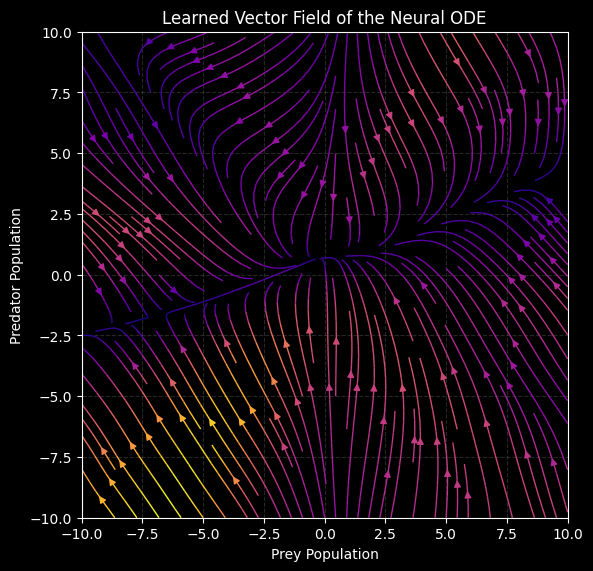

--- Starting PyTorch NODE Training ---
Epoch: 750/3_000 | Loss: 0.138230
Epoch: 1_500/3_000 | Loss: 0.055518
Epoch: 2_250/3_000 | Loss: 0.038752
Epoch: 3_000/3_000 | Loss: 0.034333


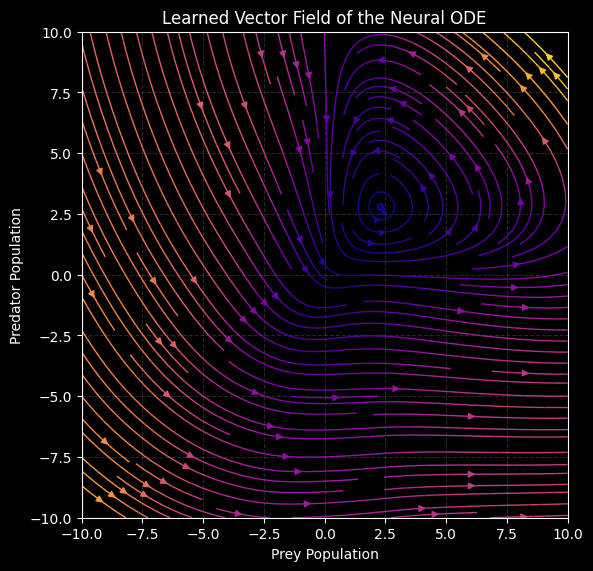

In [37]:
# Train the model
X_true_torch, Y_true_torch = get_predator_prey_dataset(on_torch=True)
train_torch_node(
    model_torch_node,
    weight_decay=1e-4,
    lr=5e-3,
    X=X_true_torch,
    Y=Y_true_torch,
    epochs=3_000,
    rtol=1e-3,
    atol=1e-4,
)

"It cannot simply memorize the mapping for each point. It has to find a single, smooth vector field that on average best describes the flow for all 100 points. "

In [38]:
model_torch_node.eval()
with torch.no_grad():
    Y_pred: torch.Tensor = model_torch_node(X_true_torch)
accuracy = calculate_tolerance_accuracy(Y_pred.cpu().detach().numpy(), Y_true_torch.cpu().detach().numpy(), 0.5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 98.00%


In [39]:
X_true_torch, Y_true_torch = get_predator_prey_dataset(
    on_torch=True, 
    n=50, 
    prey_min=10,
    prey_max=15,
    predator_min=10, 
    predator_max=15,
)
model_torch_node.eval()
with torch.no_grad():
    Y_pred: torch.Tensor = model_torch_node(X_true_torch)
    
accuracy = calculate_tolerance_accuracy(Y_pred.cpu().detach().numpy(), Y_true_torch.cpu().detach().numpy(), 0.5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 7.24%


### 4.2. Training the `torchdiffeq` NODE with `ReLU`

Finally, we test the `ReLU` activation within the `torchdiffeq` framework. This experiment will provide the clearest picture of how different non-linearities affect the ability of a NODE to learn a smooth, continuous vector field. By comparing the results to the `tanh`-based NODE and the `ReLU`-based MLP, we can draw strong conclusions about the best architectural choices for this type of problem.

In [40]:
class ODEFunc2(nn.Module):
    def __init__(self):
        super(ODEFunc2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        
    def forward(self, t, y):
        return self.net(y)

In [41]:
dynamics_func_2 = ODEFunc2()
model_torch_node_2 = NeuralODE(dynamics_func_2).to(device)

Loss before start: 3.5309


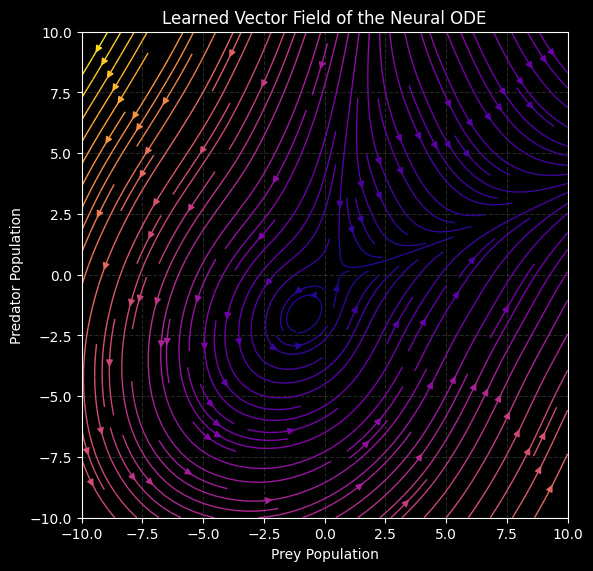

--- Starting PyTorch NODE Training ---
Epoch: 750/3_000 | Loss: 0.076166
Epoch: 1_500/3_000 | Loss: 0.024251
Epoch: 2_250/3_000 | Loss: 0.029327
Epoch: 3_000/3_000 | Loss: 0.050781


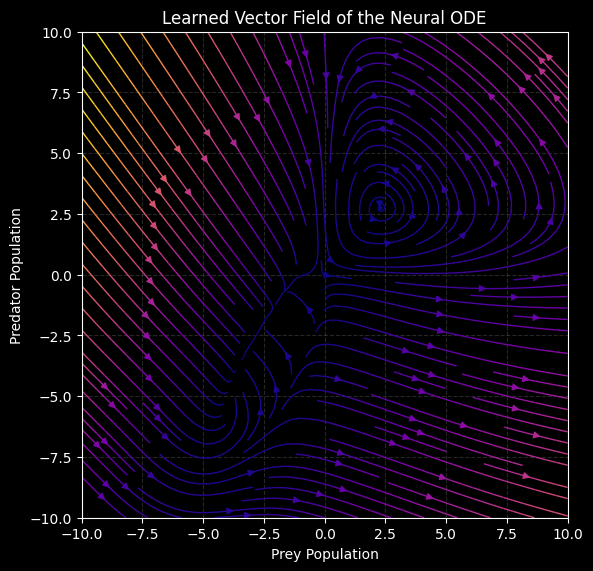

In [42]:
X_true_torch, Y_true_torch = get_predator_prey_dataset(on_torch=True)
train_torch_node(
    model_torch_node_2,
    weight_decay=1e-4,
    lr=5e-3,
    X=X_true_torch,
    Y=Y_true_torch,
    epochs=3_000,
    rtol=1e-3,
    atol=1e-4,
)

In [43]:
model_torch_node_2.eval()
with torch.no_grad():
    Y_pred: torch.Tensor = model_torch_node_2(X_true_torch)
accuracy = calculate_tolerance_accuracy(Y_pred.cpu().detach().numpy(), Y_true_torch.cpu().detach().numpy(), 0.5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 100.00%


In [44]:
X_true_torch, Y_true_torch = get_predator_prey_dataset(
    on_torch=True, 
    n=50, 
    prey_min=10,
    prey_max=15,
    predator_min=10, 
    predator_max=15,
)
model_torch_node_2.eval()
with torch.no_grad():
    Y_pred: torch.Tensor = model_torch_node_2(X_true_torch)
    
accuracy = calculate_tolerance_accuracy(Y_pred.cpu().detach().numpy(), Y_true_torch.cpu().detach().numpy(), 0.5)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 89.60%


## Visualizing the Ground Truth: The Lotka-Volterra Phase Portrait

Before we attempt to learn the predator-prey dynamics, it is essential to understand what the "ground truth" looks like. The behavior of the Lotka-Volterra system is best visualized through a **phase portrait**, which shows the vector field of the system's dynamics.

Each arrow in the plot represents the instantaneous velocity (the direction and magnitude of change) at a specific point in the state space of (prey, predator) populations. The flowing lines, or streamlines, trace the trajectories that populations would follow over time from different starting points.

The key feature to observe is the set of **closed, cyclical orbits** around a central equilibrium point. This indicates that the populations of prey and predators will oscillate in a stable, repeating pattern. This is the exact non-linear behavior that our Neural ODE models will attempt to learn and replicate. The following function plots this ground-truth vector field.


In [45]:
def view_predator_prey(X_min: float=-10, X_max:float=10, Y_min:float=-10, Y_max:float=10):
    # Parameters and time span
    alpha, beta, delta, gamma = 1.1, 0.4, 0.4, 0.9
    t_span = [0, 1.0]

    # --- Plot ---
    plt.style.use("dark_background")
    cmap = plt.get_cmap("plasma")

    fig, ax = plt.subplots(figsize=(6, 6))

    # Build grid for vector field
    x_vals = np.linspace(X_min, X_max, 20)
    y_vals = np.linspace(Y_min, Y_max, 20)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Compute derivatives on grid
    dXdT, dYdT = predator_prey([], [X, Y], alpha, beta, delta, gamma)

    M = np.hypot(dXdT, dYdT)
    norm = mcolors.Normalize(vmin=np.min(M), vmax=np.max(M))

    ax.streamplot(X, Y, dXdT, dYdT, color=M, cmap=cmap, norm=norm, linewidth=1.5, density=1.5)

    # --- Legends Phase Space ---
    ax.set_title("Predator-Prey Phase Portrait")
    ax.set_xlabel("Prey (x)")
    ax.set_ylabel("Predator (y)")
    ax.grid(color="gray", linestyle="--", alpha=0.3)
    ax.set_aspect("equal")

    plt.tight_layout()
    plt.show()

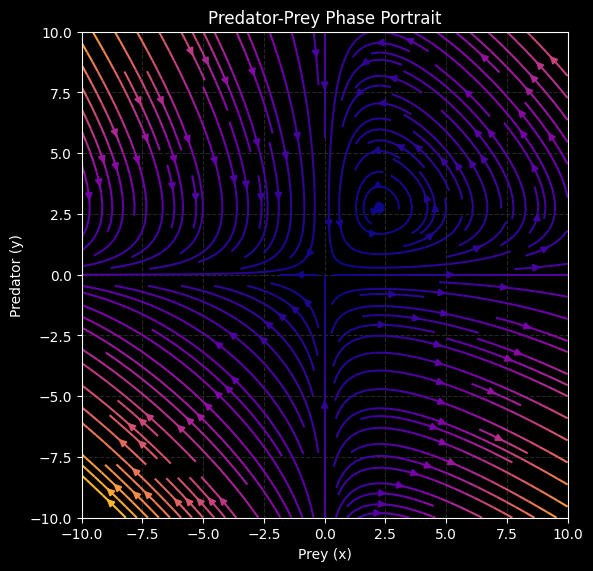

In [46]:
view_predator_prey()